In [1]:
from typing import Union, Tuple, List

import os
import pandas as pd
import seaborn as sns
import scipy
import numpy as np
import random
from matplotlib import pyplot as plt
from datetime import datetime
from tqdm import tqdm

%matplotlib inline

from IPython.display import Image

import warnings
warnings.filterwarnings("ignore")

In [2]:
seed = 0

random.seed(seed)
np.random.seed(seed)

In [16]:
base_path = os.path.join(os.curdir, 'data')
data_path = os.path.join(base_path, 'ml-1m')

In [23]:
rating_path = os.path.join(data_path, 'ratings.dat')

# 무비렌즈 학습 데이터
ratings_df = pd.read_csv(rating_path, encoding='utf-8', sep='::', header=None)
ratings_df.columns = ["userId", "movieId", "rating", "timestamp"]

In [24]:
ratings_df.head()

,userId,movieId,rating,timestamp
0,1,1193,5,978300760
1,1,661,3,978302109
2,1,914,3,978301968
3,1,3408,4,978300275
4,1,2355,5,978824291


---

SGD 기반 MF 모델 구현

<p style="font-size:20px">
$$b_u \leftarrow b_u + \gamma (e_{ui} - \lambda b_u )$$
$$b_i \leftarrow b_i + \gamma (e_{ui} - \lambda b_i )$$
$$p_u \leftarrow p_u + \gamma (e_{ui} \cdot q_i - \lambda p_u )$$
$$q_i \leftarrow q_i + \gamma (e_{ui} \cdot p_u - \lambda q_i )$$
</p>

In [25]:
def sgd(
    P: np.ndarray,
    Q: np.ndarray,
    b: float,
    b_u: np.ndarray,
    b_i: np.ndarray,
    samples: List[Tuple],
    learning_rate: float,
    regularization: float
) -> None:

    for user_id, item_id, rating in samples:
        
        # 1. 현재 주어진 파라미터로 predicted rating을 구함
        predicted_rating = b + b_u[user_id] + b_i[item_id] + P[user_id, :].dot(Q[item_id, :].T)
        
        # 2. 실제 rating과 predicted rating의 차이로 error를 구함
        error = (rating - predicted_rating)
        
        # 3. 2.에서 구한 error를 통해 유저와 아이템의 bias 업데이트
        b_u[user_id] += learning_rate * (error - regularization * b_u[user_id])
        b_i[item_id] += learning_rate * (error - regularization * b_i[item_id])
        
        # 4. 2.에서 구한 error를 통해 유저와 아이템의 잠재 요인 행렬 업데이트
        P[user_id, :] += learning_rate * (error * Q[item_id, :] - regularization * P[user_id,:])
        Q[item_id, :] += learning_rate * (error * P[user_id, :] - regularization * Q[item_id,:])


- bias가 없을 때
<p style="font-size:20px">$$\hat{R} = PQ^T$$</p>
- bias가 있을 때
<p style="font-size:20px">$$\hat{R} = PQ^T + \mathbb{1}_{|U|}b_i ^ T + b_u \mathbb{1}_{|I|}^{T} + b \mathbb{1}_{|U|} \mathbb{1}_{|I|}^{T} $$</p>


In [26]:
def get_predicted_full_matrix(
    P: np.ndarray,
    Q: np.ndarray,
    b: float = None,
    b_u: np.ndarray = None,
    b_i: np.ndarray = None
) -> np.ndarray:

    if b is None:
        return P.dot(Q.T)
    else:
        return b + b_u[:, np.newaxis] + b_i[np.newaxis, :] + P.dot(Q.T)



<p style="font-size:20px">$$RMSE(\hat{\theta}) = \sqrt{MSE(\hat{\theta})} = \sqrt{\mathbb{E}({(\hat{\theta} - \theta)}^2)}$$</p>

In [27]:
def get_rmse(
    R: np.ndarray,
    predicted_R: np.ndarray
) -> float:

    user_index, item_index = R.nonzero()
    error = list()
    for user_id, item_id in zip(user_index, item_index):
        square_error = pow(R[user_id, item_id] - predicted_R[user_id, item_id], 2)
        error.append(square_error)
    rmse = np.sqrt(np.asarray(error).mean())
    return rmse
    

In [28]:
class MF(object):
    
    def __init__(self, R, K, learning_rate, regularization, epochs, verbose=False):
        self.R = R
        self.num_users, self.num_items = R.shape
        self.K = K
        self.learning_rate = learning_rate
        self.regularization = regularization
        self.epochs = epochs
        self.verbose = verbose
        
        self.training_process = list()
    
    def train(self):
        
        # 유저, 아이템 잠재 요인 행렬 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # 글로벌, 유저, 아이템 bias 초기화
        self.b = np.mean(self.R[np.where(self.R != 0)])
        self.b_u = np.zeros(self.num_users)
        self.b_i = np.zeros(self.num_items)

        # 학습 데이터 생성
        self.samples = [
            (i, j, self.R[i, j])
            for i in range(self.num_users)
            for j in range(self.num_items)
            if self.R[i, j] > 0
        ]
        
        for epoch in range(1, self.epochs + 1):
            np.random.shuffle(self.samples)
            sgd(self.P, self.Q, self.b, self.b_u, self.b_i, self.samples, self.learning_rate, self.regularization)
            predicted_R = self.get_predicted_full_matrix()
            rmse = get_rmse(self.R, predicted_R)
            self.training_process.append((epoch, rmse))
            if self.verbose and (epoch % 10 == 0):
                print("epoch: %d, error = %.4f" % (epoch, rmse))
        
        self.training_process = pd.DataFrame(self.training_process, columns = ['epoch', 'rmse'])
    
    def get_predicted_full_matrix(self):
        return get_predicted_full_matrix(self.P, self.Q, self.b, self.b_u, self.b_i)

In [29]:
user_item_matrix = ratings_df.pivot_table(values='rating', index='userId', columns='movieId').fillna(0)

# 유저-아이템 rating 매트릭스
R = user_item_matrix.to_numpy()

# 잠재 요인 수
K = 20

# learning rate
learning_rate = 0.01

# l2 정규화 파라미터
regularization = 0.2

# 총 epoch 수
epochs = 30

# 학습 과정의 status print 옵션
verbose = True

In [30]:
user_item_matrix.head()

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,5.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [31]:
mf = MF(R, K, learning_rate, regularization, epochs, verbose)

In [32]:
mf.train()

epoch: 10, error = 0.9076
epoch: 20, error = 0.9071
epoch: 30, error = 0.9061


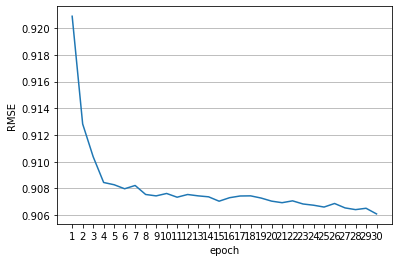

In [33]:
train_result_df = mf.training_process

x = train_result_df.epoch.values
y = train_result_df.rmse.values
plt.plot(x, y)
plt.xticks(x, x)
plt.xlabel("epoch")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

In [34]:
predicted_user_item_matrix = pd.DataFrame(mf.get_predicted_full_matrix(), columns=user_item_matrix.columns, index=user_item_matrix.index)

predicted_user_item_matrix

movieId,1,2,3,4,5,6,7,8,9,10,...,3943,3944,3945,3946,3947,3948,3949,3950,3951,3952
userId,,,,,,,,,,,,,,,,,,,,,
1,4.331443,3.543651,3.442314,3.219010,3.407481,4.148671,3.752155,3.404916,3.128040,3.896422,...,3.501432,2.807220,2.211083,2.763613,3.805050,3.856863,4.276213,3.904465,4.170584,3.992786
2,4.044597,3.258879,3.157877,2.933497,3.123918,3.861867,3.467463,3.119862,2.844763,3.611504,...,3.215172,2.520994,1.925959,2.480507,3.517310,3.571198,3.987493,3.617422,3.883736,3.706334
3,4.186024,3.400585,3.299606,3.075077,3.265771,4.003298,3.609154,3.261518,2.986671,3.753180,...,3.356626,2.662981,2.067585,2.622458,3.658440,3.712788,4.128674,3.758830,4.025247,3.847832
4,4.250490,3.459395,3.357597,3.135836,3.321137,4.067725,3.667766,3.320833,3.041559,3.812458,...,3.419401,2.723478,2.127514,2.676613,3.725416,3.774110,4.198317,3.823784,4.090335,3.911204
5,3.620266,2.823456,2.720767,2.502018,2.681887,3.437442,3.031658,2.685831,2.401391,3.176941,...,2.787862,2.091320,1.492808,2.036507,3.097173,3.140673,3.573422,3.193625,3.460043,3.280060
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6036,3.844287,3.045942,2.943027,2.725080,2.903469,3.661428,3.254096,2.908494,2.622752,3.399535,...,3.011429,2.314386,1.715590,2.257836,3.321786,3.363804,3.798806,3.417703,3.684059,3.503768
6037,3.899878,3.110361,3.008788,2.786338,2.973139,3.717114,3.318814,2.971807,2.693528,3.463277,...,3.069425,2.374318,1.778226,2.329036,3.374034,3.424352,3.846275,3.472884,3.739177,3.560943
6038,3.968684,3.180437,3.079115,2.855961,3.043976,3.785935,3.388893,3.041597,2.764493,3.533256,...,3.138576,2.443239,1.848320,2.399352,3.440806,3.493934,3.913841,3.542608,3.807531,3.630077


---

In [73]:
# Target User에 대해, 한 번도 보지 못한 item의 preference score를 예측 후 내림차순으로 정렬

TARGET_USER = 1

mask = user_item_matrix.loc[TARGET_USER, :].eq(0)

User_preference = predicted_user_item_matrix.loc[TARGET_USER, mask]

User_preference.sort_values(ascending=False, inplace=True)


In [74]:
User_preference

movieId
2503    4.827831
53      4.766286
2905    4.753124
3245    4.713911
318     4.659122
          ...   
810     2.109123
1323    2.080388
1495    2.065955
3574    2.024337
1311    1.893721
Name: 1, Length: 3653, dtype: float64